<a href="https://colab.research.google.com/github/Justawayx/microbe_tracking/blob/master/Find_coords_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/image_segmentation/Data

/content/drive/.shortcut-targets-by-id/1oL1IKgNdUkjyUG9U8GsIIiZwuLk7-0r1/image_segmentation/Data


In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from skimage import filters
from skimage.color import rgb2gray
import math
import cv2
import glob
import random as rand
from matplotlib import pyplot as plt
import scipy
from scipy import ndimage, signal

tf.compat.v1.disable_eager_execution()

In [ ]:
# ====================================
# Define preprocessing functions
# ====================================

def normalize_intensity(img):
  # Intensity normalization (linear)
  normMax, normMin = 1.0, 0.0
  normRange = normMax - normMin
  imgMax, imgMin = img.max(), img.min()
  imgRange = imgMax - imgMin
  img_norm = (img - imgMin) * (normRange/imgRange) + normMin
  return img_norm

def Gaussian(size,sigma):
    yi, xi = np.mgrid[0:size, 0:size] - np.floor(size/2) # Assumes odd size
    G = (1/(2*np.pi*(sigma**2)))*np.e**(-1*((xi**2)+(yi**2))/(2*(sigma**2)))
    return G

def preprocess(img):
    img_8u = np.uint8(img*255) # Range 0-255
    img_gray = cv2.cvtColor(img_8u, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    img_f1 = cv2.fastNlMeansDenoising(img_gray, None, h=9) # Denoise (originally 12)
    img_f2 = signal.convolve2d(img_f1, Gaussian(9, 2), mode='same') # Gaussian filter
    img_f3 = cv2.Laplacian(img_f2, cv2.CV_8U, ksize=5) # Laplacian filter
    # th_otsu = filters.threshold_otsu(img_f3) # Otsu threshold for background
    # img_f3[img_f3 <= th_otsu] = 0

    return img_f3 # img_f3

def get_images(img_dir):
    data_path = os.path.join(img_dir,'*g')
    files = sorted(glob.glob(data_path))
    imgs = [cv2.imread(file) for file in files]
    return np.array(imgs)

def develop_features_v2(img_dir, num_frames):
    data_path = os.path.join(img_dir,'*g')
    files = sorted(glob.glob(data_path))
    
    imgs_processed = []
    progress = 0
    for file in files:
        img = cv2.imread(file)
        img_norm = normalize_intensity(img)
        imgs_processed.append(preprocess(img_norm))
        progress += 1
        if progress % 10 == 0:
            print("Done processing %s images\r" % progress)
        if progress == num_frames:
            break

    
    imgs_processed = np.array(imgs_processed)
    m, n, o = imgs_processed.shape
    return np.reshape(imgs_processed, (m,n,o,1))


# centroid_locs, ploc should be numpy arrays
def min_edist_to_centroid(centroid_locs, ploc):
    ploc = ploc.reshape(1,2)
    diffs = scipy.spatial.distance.cdist(ploc,centroid_locs)
    return diffs.min()


def centroids_to_pmap(img_shape, centroid_locs):
    h = img_shape[0]
    w = img_shape[1]
    frame = np.zeros(img_shape)

    for index in np.ndindex(h,w):
        x, y = index
        frame[y, x] = math.exp(-1/50 * min_edist_to_centroid(centroid_locs, np.array(index)))
    return frame

def get_predeveloped_labels(folder_path = 'centroidPMaps/'):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    for file in files:
      img = cv2.imread(folder_path + file)
      img_8u = np.uint8(img*255) # Range 0-255
      img_gray = cv2.cvtColor(img_8u, cv2.COLOR_BGR2GRAY) # Convert to grayscale
      frames.append(img_gray)    
    frames = np.array(frames)
    m,n,o = frames.shape
    return np.reshape(frames, (m,n,o,1))

def develop_labels(folder_path, img_shape):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    
    progress = 0
    for file in files:
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            for line in f:
                x, y = line.split()
                frame.append((int(x), int(y)))
                cur_max += 1

            frame = np.array(frame)
            frames.append(centroids_to_pmap(img_shape, frame))
        progress += 1
        print("Done processing %s images\r" % progress)

    frames = np.array(frames)
    m,n,o = frames.shape

    return np.reshape(frames, (m,n,o,1))

def get_centroids(folder_path):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    for file in files:
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            for line in f:
                x, y = line.split()
                frame.append((int(x), int(y)))
            frame = np.array(frame)
            frames.append(frame)
    frames = np.array(frames)
    return frames


def develop_heatmap_labels(folder_path):
    files = sorted([f for f in os.listdir(folder_path)])
    num_maps = len(files)

    heat_maps = np.zeros((num_maps, 1024, 1024))
    mesh_grid = np.array(np.meshgrid([range(1024)],[range(1024)]), dtype='float32')
    mesh_grid = np.tile(np.reshape(mesh_grid, (1, 2, 1024, 1024)), (128,1,1,1))
    i = 0
    for file in files:
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            labels = list()
            for line in f:
                x, y = line.split()
                labels.append((int(x), int(y)))
                cur_max += 1

            labels = np.pad(np.array(labels, dtype='float32'), ((0,128 - cur_max),(0,0)), mode='constant', constant_values=0)
            labels = np.reshape(labels, (128, 2, 1, 1))
            heat_maps[i,:,:] = np.exp(-1/50 * (np.min(np.sqrt(np.sum(np.square(mesh_grid - labels), axis=1)), axis=0)))
            i += 1

            if i % 10 == 0:
                print('Finished processing %s heatmaps.' % i)
    return heat_maps

def develop_random_heatmap_labels(num_maps):

    labels = np.random.randint(1024, size=(num_maps,128, 2, 1, 1)).astype('float32')
    heat_maps = np.zeros((num_maps, 1024, 1024))
    mesh_grid = np.array(np.meshgrid([range(1024)],[range(1024)]), dtype='float32')
    mesh_grid = np.tile(np.reshape(mesh_grid, (1, 2, 1024, 1024)), (128,1,1,1))


    for i in range(num_maps):
        print(i)
        num_zero_centroids = rand.randint(0, 128)
        labels[i,127-num_zero_centroids:128,:,:,:] = np.zeros((num_zero_centroids + 1,2,1,1))
        heat_maps[i,:,:] = np.exp(-1/50 * (np.min(np.sqrt(np.sum(np.square(mesh_grid - labels[i,:,:,:,:]), axis=1)), axis=0)))

    return heat_maps, labels


def crop_images(labels, features, num, with_mixup = False):
    labels_crop = list()
    features_crop = list()

    for i in range(num):
        while True:
            image = np.random.choice(labels.shape[0])
            x = np.random.choice(labels.shape[1] - 192) + 64
            y = np.random.choice(labels.shape[2] - 192) + 64

            if np.sum(labels[image, x:x+64,y:y+64, 0]) >= (64 ** 2) * 0.05:

                current_labels = labels[image, x:x+64,y:y+64, :]
                if with_mixup:
                    lam = np.reshape(np.random.beta(1, 1, 64*64), (64,64,1))
                    x_j = np.reshape(np.random.choice(64,64*64), (64,64,1))
                    y_j = np.reshape(np.random.choice(64,64*64), (64,64,1))
                    y_j = labels[image, x_j, y_j]
                    current_labels = np.where((1 - lam > 0.9) & (y_j == 1), 1, current_labels)

                labels_crop.append(current_labels)
                features_crop.append(features[image,x:x+64,y:y+64])
                break

    return np.asarray(labels_crop, dtype='uint8'), np.asarray(features_crop, dtype='uint8')

In [ ]:
# ======================
# Heatmap preprocessing
# ======================

def invert_and_scale_heatmaps(labels):
  labels_mod = []
  for label in labels:
    img = label[:,:,0]
    # Only invert if closest pixels have high values
    # and farthest/background pixels have low values;
    # Goal is for closest pixels to have value 0
    inverted_img = np.invert(img)
    scaled_img = np.exp((-1 * inverted_img / 30) + 2)
    h, w = scaled_img.shape
    labels_mod.append(scaled_img.reshape(h, w, 1))
  return np.array(labels_mod)

def threshold_heatmaps(labels, direction='>', threshold_frac=0.5):
  if direction not in ['>', '<']:
    print("Your options for direction are > or <")
    return None
  labels_mod = np.copy(labels)
  for i in range(len(labels_mod)):
    img = labels_mod[i][:,:,0]
    irange = img.max() - img.min()
    threshold = img.min() + threshold_frac*irange
    if direction == '>':
      img[img > threshold] = threshold
    elif direction == '<':
      img[img < threshold] = threshold
    labels_mod[i] = img.reshape(img.shape[0], img.shape[1], 1)
  return labels_mod

def normalize_heatmaps(labels):
  # Namely turn into 0-1
  labels_mod = []
  for label in labels:
    img = label[:,:,0]
    img = normalize_intensity(img)
    h, w = img.shape
    labels_mod.append(img.reshape(h, w, 1))
  return np.array(labels_mod)

In [ ]:
# ====================================
# Run preprocessing!
# ====================================

'''
heat_maps = develop_heatmap_labels('newCentroids/')
m, n, o = heat_maps.shape
labels = heat_maps.reshape(m, n, o, 1)
print(labels.shape)
'''

# labels = develop_labels('newCentroids/', (1024, 1024))
# labels = get_predeveloped_labels()
# labels = invert_and_scale_heatmaps(labels)
# labels = threshold_heatmaps(labels, '<', 0.1)
# labels = normalize_heatmaps(labels)
print(labels.shape)

features = develop_features_v2('newFrames/', labels.shape[0])
print(features.shape)

# test_labels, test_features = crop_images(labels, features, 12000)
# train_labels, train_features = crop_images(labels, features, 120000)

(201, 1024, 1024, 1)
Done processing 10 images
Done processing 20 images
Done processing 30 images
Done processing 40 images
Done processing 50 images
Done processing 60 images
Done processing 70 images
Done processing 80 images
Done processing 90 images
Done processing 100 images
Done processing 110 images
Done processing 120 images
Done processing 130 images
Done processing 140 images
Done processing 150 images
Done processing 160 images
Done processing 170 images
Done processing 180 images
Done processing 190 images
Done processing 200 images
(201, 1024, 1024, 1)


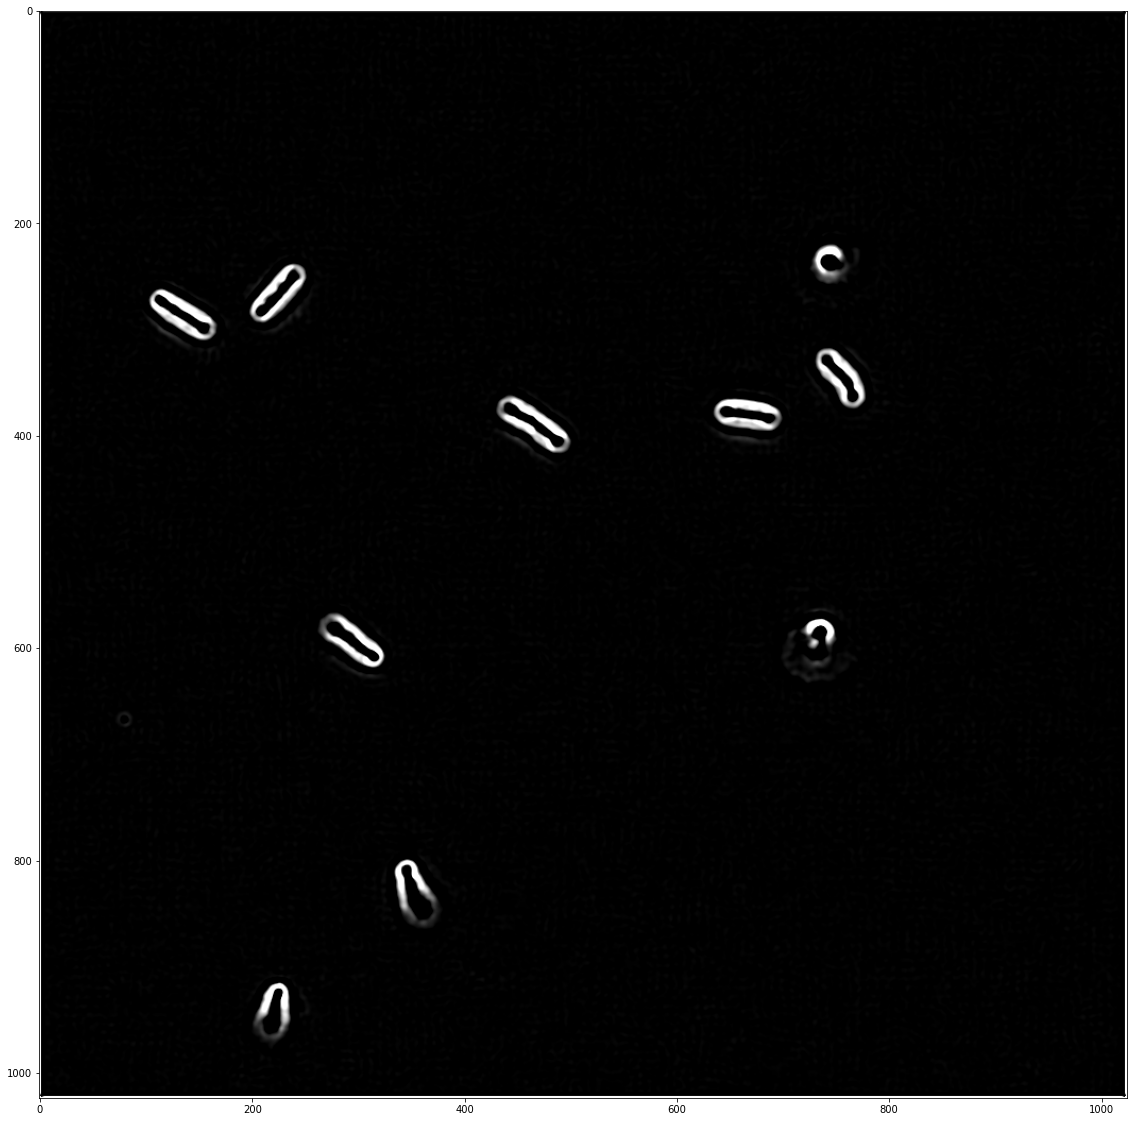

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(features[0,:,:,0], cmap='gray') # Keep noise this time

In [ ]:
# ====================================
# Define loss functions and NN model
# ====================================


def Weighted_cross_entropy_loss(beta = 1):
  def convert_to_logits(y_pred):
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.math.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

  return loss


def Dice_loss():
    def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

    return loss


def Tversky_loss(beta):
    def loss(y_true, y_pred):
      numerator = tf.reduce_sum(y_true * y_pred, axis=-1)
      denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

      return 1 - (numerator + 1) / (tf.reduce_sum(denominator, axis=-1) + 1)

    return loss


def centroid_loss():
    def loss(y_true, y_pred):
        mesh_grid = tf.meshgrid(np.arange(0, 1024), np.arange(0, 1024))
        mesh_grid = tf.repeat(mesh_grid, repeats = 128, axis=0)
        distance = tf.min(tf.keras.backend.sum(tf.keras.backend.square(tf.keras.backend.reshape(y_true, (-1, 128, 1, 1)) - mesh_grid)), axis=0)

def code_block_encode(prev_layer, filters):
    layer_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(prev_layer)   
    layer_2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(layer_1)
    layer_3 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(layer_2)

    return layer_3


def code_block_decode(prev_layer, encoding_layer, filters, dropout = 0.5):
    layer_1 = tf.keras.layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same', activation='relu')(prev_layer)
    layer_2 = tf.keras.layers.concatenate([encoding_layer, layer_1])
    layer_3 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(layer_2)
    layer_4 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(layer_3)

    return layer_4


def create_UNet(img_dim, filters):
    input = tf.keras.layers.Input(shape=img_dim[1:], dtype='float32')
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(input)
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(input_block)


    filters *=2
    encode_block1 = code_block_encode(input_block, filters)
    filters *= 2
    encode_block2 = code_block_encode(encode_block1, filters)
    filters *= 2
    encode_block3 = code_block_encode(encode_block2, filters)
    filters *= 2
    descriptors = code_block_encode(encode_block3, filters)
    filters /= 2
    decode_block3 = code_block_decode(descriptors, encode_block3, filters)
    filters /= 2
    decode_block2 = code_block_decode(decode_block3, encode_block2, filters)
    filters /= 2
    decode_block1 = code_block_decode(decode_block2, encode_block1, filters)
    filters /= 2
    output = code_block_decode(decode_block1, input_block, filters)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(output)

    model = tf.keras.Model(inputs=input, outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


In [ ]:
# ====================================
# Run the NN!
# ====================================

model = create_UNet(np.shape(features), 16)
model.summary()
model.fit(features[1:,:,:,:], labels[1:,:,:,:], epochs=16, batch_size=4, validation_split=0.1)
# model.evaluate(features[1350:,:,:,:], labels[1350:,:,:,:], batch_size=256)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 1024, 1024, 1 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 1024, 1024, 1 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 512, 512, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
# June 11, 11:58 PM
# 10th epoch: loss 0.3612, val_loss 0.5450

# June 16, 11:45 PM
# 16th epoch: loss 0.1845, val_loss 0.3580

# June 18, 7:07 PM - no input preprocessing
# 16th epoch: loss 0.0957, val_loss 0.2006

In [ ]:
# ====================================
# Save the NN!
# ====================================

model.save('Find_coords_v4_model.h5')

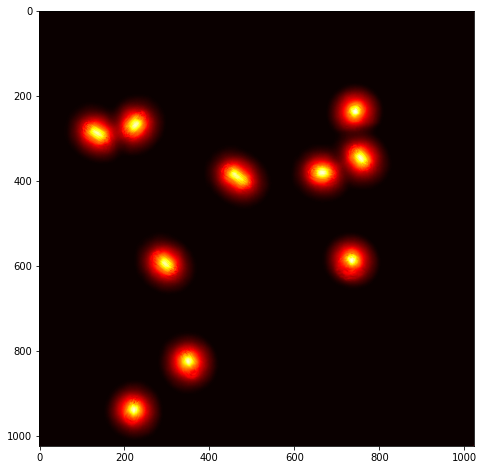

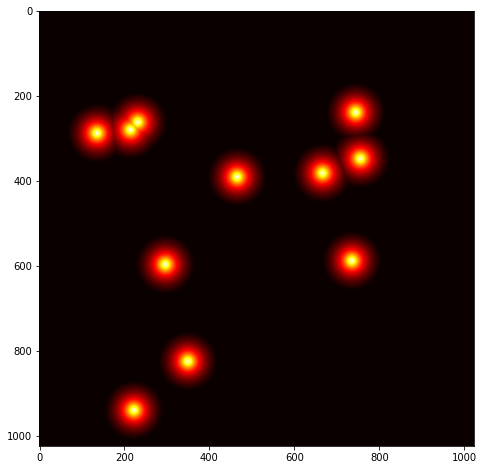

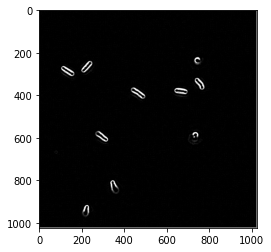

In [ ]:
# ====================================
# Try prediction
# ====================================

img = 0

# Predicted
pred = np.reshape((model.predict(features[img:img+1,:,:,:])), (1024, 1024))
plt.figure(figsize=(8,8))
plt.imshow(pred, cmap='hot')

# Label
plt.figure(figsize=(8,8))
plt.imshow(labels[img,:,:,0], cmap='hot')

# Original image
plt.figure()
plt.imshow(features[img,:,:,0], cmap='gray')

In [ ]:
# ====================================
# Heatmap to centroid prediction:
# Local search/clustering approach
# ====================================

cpy = np.copy(pred)

idxs_interest = np.argwhere(cpy>0.82)

clusters = []
idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy

for cur_idx in idxs_interest:

  cur_idx = tuple(cur_idx)

  # Already counted in previous cluster
  if cur_idx not in idxs_remaining:
    continue
  
  # Create new cluster    
  idxs_remaining.remove(cur_idx)
  cluster = build_cluster(cur_idx, idxs_remaining)
  cluster.append(cur_idx)
  
  # Add new cluster to list of clusters
  clusters.append(cluster)

NameError: ignored

[(65, 776), (89, 183), (123, 840), (129, 882), (138, 751), (141, 670), (148, 259), (149, 222), (181, 676), (185, 998), (202, 393), (213, 624), (221, 54), (247, 1002), (248, 874), (249, 530), (252, 95), (291, 956), (297, 536), (301, 122), (308, 914), (310, 23), (314, 855), (329, 323), (384, 925), (421, 98), (436, 139), (453, 110), (457, 530), (461, 236), (490, 155), (502, 763), (502, 459), (533, 422), (533, 314), (541, 104), (560, 45), (558, 60), (579, 114), (597, 384), (597, 920), (645, 578), (664, 668), (690, 582), (688, 30), (701, 452), (702, 74), (714, 66), (734, 613), (742, 775), (747, 96), (749, 938), (757, 940), (773, 26), (785, 546), (787, 790), (791, 78), (805, 195), (841, 42), (865, 434), (874, 561), (917, 530), (911, 542), (951, 126), (952, 831), (968, 560), (985, 956), (993, 494), (990, 9), (1009, 238)]
There are 70 predicted centroids


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


There are 93 real centroids


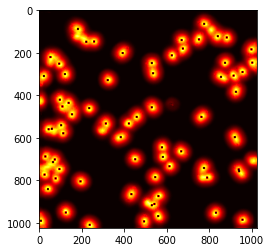

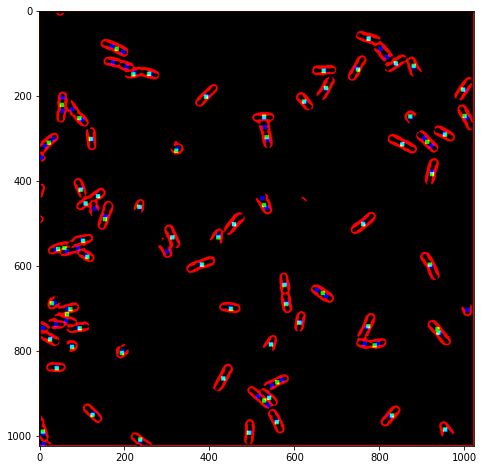

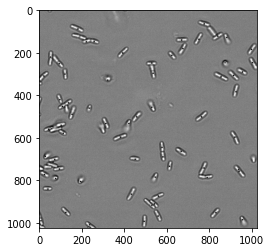

In [ ]:
# Centroid predictions

centroids = [find_cluster_center(cluster, cpy) for cluster in clusters]

print(centroids)
print("There are %s predicted centroids" % len(centroids))

cpy_heatmap = np.copy(pred)
cpy_orig = np.copy(features[img,:,:,0])
cpy_orig_c2 = np.zeros(features[img,:,:,0].shape)

real_images = get_images('newFrames/')
cpy_super_orig = np.copy(real_images[img])

for x, y in centroids:
  cpy_heatmap[x-5:x+5,y-5:y+5] = 0
  cpy_orig_c2[x-5:x+5,y-5:y+5] = 200
  cpy_super_orig[x-3:x+3,y-3:y+3] = 0

cpy_orig_c3 = np.zeros(features[img,:,:,0].shape)

real_centroids = get_centroids('newCentroids/')
print("There are %s real centroids" % len(real_centroids[img]))

for y, x in real_centroids[img]:
  cpy_orig_c3[x-5:x+5,y-5:y+5] = 200

cpy_orig_labelled = np.dstack([cpy_orig, cpy_orig_c2, cpy_orig_c3])

plt.figure()
plt.imshow(cpy_heatmap, cmap='hot')

plt.figure(figsize=(8, 8))
plt.imshow(cpy_orig_labelled)

plt.figure()
plt.imshow(cpy_super_orig)

In [ ]:
# Test data

from skimage.transform import rotate

def expand_data_rotate(features, labels):
  # Assume same number of features and labels
  num, h, w, d = features.shape
  extra_features = []
  extra_labels = []
  for i in range(num):
    orig_feature = features[i,:,:,0]
    orig_pmap = labels[i,:,:,0]
    rotated_feature = rotate(orig_feature, 90, preserve_range=True)
    rotated_pmap = rotate(orig_pmap, 90, preserve_range=True)
    extra_features.append(rotated_feature.reshape(h, w, 1))
    extra_labels.append(rotated_pmap.reshape(h, w, 1))
  extra_features = np.array(extra_features)
  extra_labels = np.array(extra_labels)
  return extra_features, extra_labels

extra_features, extra_labels = expand_data_rotate(features, labels)

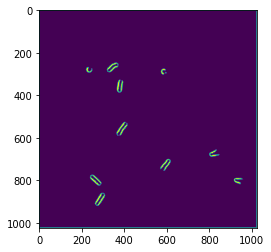

In [ ]:
plt.imshow(extra_features[0,:,:,0])

In [ ]:
results = model.evaluate(extra_features, extra_labels, batch_size=4)

In [ ]:
print("Test loss: " + str(results[0]))

Test loss: 0.10742216546144058


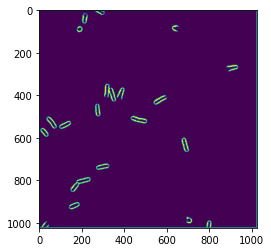

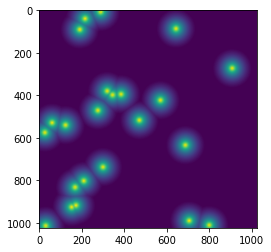

In [ ]:
img = 100

plt.figure()
plt.imshow(features[87,:,:,0])
plt.figure()
plt.imshow(labels[87,:,:,0])

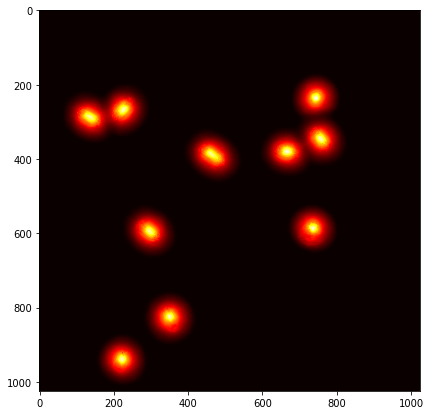

In [ ]:
# ====================================
# Try prediction
# ====================================

img = 0

#predict
pred = np.reshape((model.predict(features[img:img+1,:,:,:])), (1024, 1024))
plt.figure(figsize=(7, 7))
plt.imshow(pred, cmap='hot')

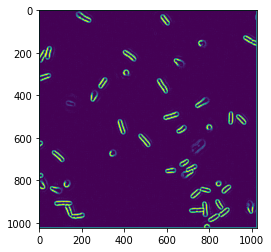

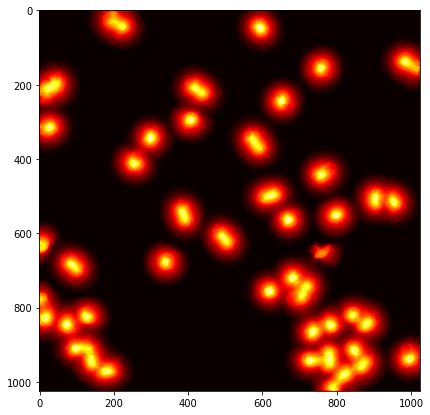

In [ ]:
img = features[120,:,:,0]
rotated_img = rotate(img, 90, preserve_range=True)
plt.imshow(rotated_img)

rotated_feature = rotated_img.reshape(1, 1024, 1024, 1)

pred = model.predict(rotated_feature)
plt.figure(figsize=(7, 7))
plt.imshow(pred[0,:,:,0], cmap='hot')

In [ ]:
print(extra_features[0,:,:,0].shape)


(1024, 1024)


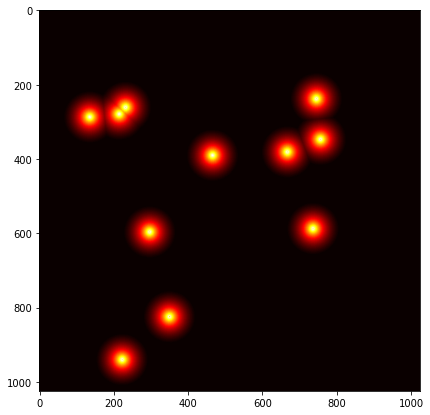

In [ ]:
#label
plt.figure(figsize=(7, 7))
plt.imshow(labels[img,:,:,0], cmap='hot')

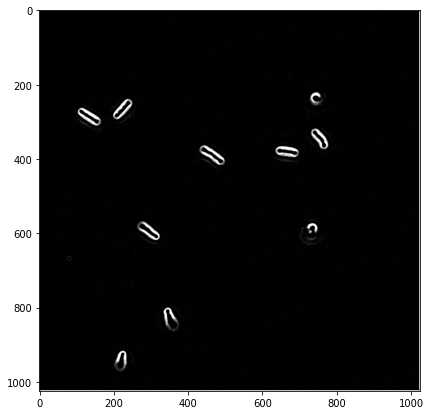

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(features[img,:,:,0], cmap='gray')

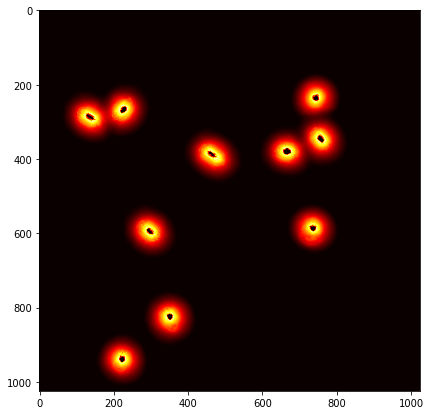

In [ ]:
# ====================================
# Heatmap to centroid prediction
# ====================================

# Idea: only examine regions with minimum intensity threshold
# Closer to centroid, closer to value 1

cpy = np.copy(pred)

idxs_interest = np.argwhere(cpy>0.75)

for x, y in idxs_interest:
  cpy[x, y] = 0

plt.figure(figsize=(7,7))
plt.imshow(cpy, cmap='hot')

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(real_images[100])

NameError: ignored

<Figure size 504x504 with 0 Axes>

In [ ]:
def build_cluster(cur_idx, idxs_remaining):
  # Explore square region of fixed size around cur_idx
  # If nothing, just return empty list
  # If you find anything, recursively call build_cluster
  # and return list of indices to add to cluster

  # Note the return value excludes cur_idx itself!
  # and assume cur_idx is already removed from idxs_remaining!

  x, y = cur_idx
  local_members = []
  all_new_members = []

  if idxs_remaining == []:
    return []
  
  for i in range(-4, 5):
    for j in range(-4, 5):
      nx, ny = x+i, y+j
      if (nx, ny) in idxs_remaining: # Found something!
        
        # Before we recurse, add all surrounding points
        # (that are not already accounted for)
        local_members.append((nx, ny))
        all_new_members.append((nx, ny))
        idxs_remaining.remove((nx, ny))
  
  for (nx, ny) in local_members:
        
    # Second pass: now recurse and add new points
    more_members = build_cluster((nx, ny), idxs_remaining)
    all_new_members += more_members
  
  return all_new_members

In [ ]:
# ====================================
# Heatmap to centroid prediction:
# Local search/clustering approach
# ====================================

cpy = np.copy(pred)

idxs_interest = np.argwhere(cpy>0.75)

clusters = []
idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy

for cur_idx in idxs_interest:

  cur_idx = tuple(cur_idx)

  # Already counted in previous cluster
  if cur_idx not in idxs_remaining:
    continue
  
  # Create new cluster    
  idxs_remaining.remove(cur_idx)
  cluster = build_cluster(cur_idx, idxs_remaining)
  cluster.append(cur_idx)
  
  # Add new cluster to list of clusters
  clusters.append(cluster)

In [ ]:
def find_cluster_center(cluster, img):
  
  best_idx = cluster[0]
  max_intensity = 0

  for idx in cluster:
    intensity = img[idx]
    if intensity > max_intensity:
      max_intensity = intensity
      best_idx = idx
  
  return best_idx

[(236, 744), (264, 231), (285, 135), (346, 756), (382, 669), (382, 460), (582, 739), (591, 298), (825, 350), (938, 223)]
There are 10 predicted centroids
There are 11 real centroids


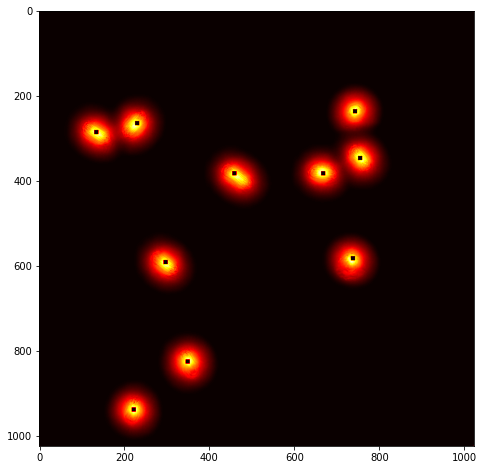

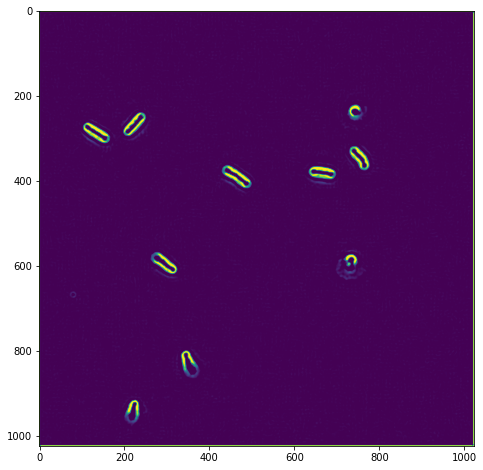

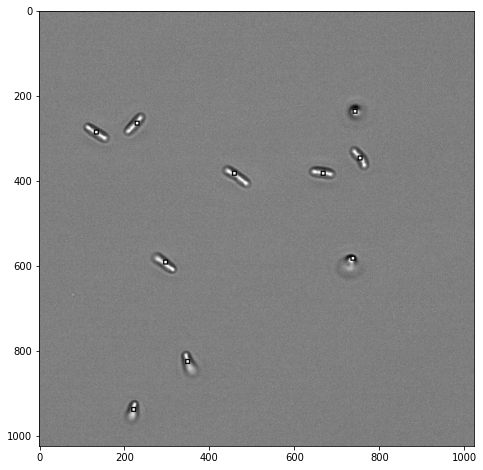

In [ ]:
# Centroid predictions

centroids = [find_cluster_center(cluster, cpy) for cluster in clusters]

print(centroids)
print("There are %s predicted centroids" % len(centroids))

cpy_heatmap = np.copy(pred)
cpy_orig = np.copy(features[img,:,:,0])
cpy_orig_c2 = np.zeros(features[img,:,:,0].shape)

real_images = get_images('newFrames/')
cpy_super_orig = np.copy(real_images[img])

for x, y in centroids:
  cpy_heatmap[x-5:x+5,y-5:y+5] = 0
  cpy_orig_c2[x-5:x+5,y-5:y+5] = 200
  cpy_super_orig[x-6:x+6,y-6:y+6] = 0
  cpy_super_orig[x-3:x+3,y-3:y+3] = 255

cpy_orig_c3 = np.zeros(features[img,:,:,0].shape)

real_centroids = get_centroids('newCentroids/')
print("There are %s real centroids" % len(real_centroids[img]))

for y, x in real_centroids[img]:
  cpy_orig_c3[x-5:x+5,y-5:y+5] = 200

cpy_orig_labelled = np.dstack([cpy_orig, cpy_orig_c2, cpy_orig_c3])

plt.figure(figsize=(8, 8))
plt.imshow(cpy_heatmap, cmap='hot')

plt.figure(figsize=(8, 8))
plt.imshow(cpy_orig)

plt.figure(figsize=(8, 8))
plt.imshow(cpy_super_orig)

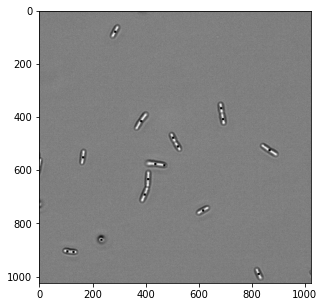

In [ ]:
# real_centroids = get_centroids('newCentroids/')
# real_images = get_images('newFrames/')

cpy_super_orig = np.copy(real_images[100])
realcs = real_centroids[100]

for y, x in realcs:
  cpy_super_orig[x-4:x+4,y-4:y+4] = 0

plt.figure(figsize=(5,5))
plt.imshow(cpy_super_orig)

In [ ]:
cur_idx = tuple(idxs_interest[0])
idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy
print(idxs_remaining[0:5])
idxs_remaining.remove(cur_idx)
print(len(idxs_remaining))
test = build_cluster(cur_idx, idxs_remaining)
print(len(test))
print(test)
print(len(idxs_remaining))

[(68, 286), (69, 285), (69, 289), (69, 290), (70, 285)]
794
88
[(69, 285), (70, 285), (71, 284), (71, 287), (72, 286), (73, 285), (73, 286), (71, 288), (73, 287), (73, 288), (74, 285), (74, 287), (74, 288), (69, 289), (69, 290), (70, 289), (70, 290), (72, 287), (72, 289), (72, 290), (73, 289), (71, 289), (72, 288), (73, 291), (74, 286), (74, 289), (72, 284), (75, 284), (75, 285), (75, 287), (75, 288), (76, 284), (76, 285), (76, 287), (76, 288), (76, 282), (76, 286), (77, 283), (77, 285), (77, 286), (75, 281), (77, 281), (77, 284), (78, 283), (78, 284), (74, 279), (72, 280), (75, 282), (79, 280), (79, 282), (79, 283), (80, 280), (80, 283), (80, 284), (81, 283), (81, 284), (82, 282), (83, 283), (84, 281), (84, 283), (82, 284), (82, 285), (84, 282), (85, 282), (80, 285), (80, 286), (83, 282), (78, 286), (78, 287), (79, 284), (79, 286), (79, 287), (81, 287), (82, 283), (77, 287), (77, 288), (79, 285), (79, 288), (80, 288), (75, 286), (78, 285), (78, 289), (76, 290), (74, 291), (77, 289), (

In [ ]:
print(len(idxs_interest))

print(len(cur_windows))

795
795


In [ ]:
# Ideas for improvement

# Number of bacteria is proportionate to some function of the fraction of high intensity pixels?

# Set expected size of cluster? So if you have an oblong cluster due to merging 
# since two centroids are very cloes together,
# can distinguish the two and cut them in half

0
102
[[102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 ...
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]]
[[102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 ...
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]
 [102 102 102 ... 102 102 102]]
61.199999999999996


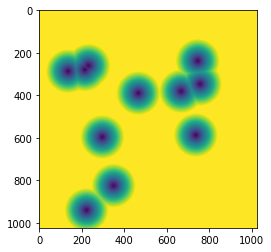

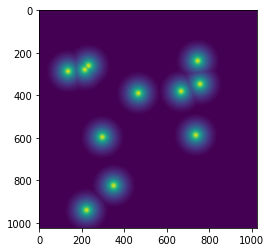

In [ ]:
# T R A S H

img = labels[0][:,:,0]

plt.figure()
plt.imshow(img)

img = np.invert(img)
plt.imshow(img)
print(img.min())
print(img.max())
print(img)
# currently, the closest pixels have highest value
# and farthest/background pixels have lowest
# want to apply exponential so 0-> large, large -> small
# invert and subtract to 0
'''
irange = img.max() - img.min()
threshold = 0.6*irange
print(threshold)
img[img<threshold] = threshold
'''

scaled_img = np.exp((-1 * img / 25) + 2.2)
plt.figure()
plt.imshow(scaled_img)

# plt.imshow(img)
print(img)
print(threshold)

labels_mod = np.copy(labels)
for label in labels_mod:
  img = label[:,:,0]
  # Only invert if closest pixels have high values
  # and farthest/background pixels have low values;
  # Goal is for closest pixels to have value 0
  img = np.invert(img)
  # Now that background has high values,
  # threshold out all too-high values
  irange = img.max() - img.min()
  threshold = img.min() + 0.6*irange
  print(img.max())
  img[img>threshold] = threshold
  print(img.max())
  plt.imshow(img)
  break
plt.imshow(labels_mod[0][:,:,0])

# There are a bunch of small contiguous regions that satisfy
# How about: in each window of size 10x10, find pixel with largest intensity
# Keep repeating until no longer have multiple pixels in window of size 10x10

# Notate window by corner pixel (with smallest coordinates)
# e.g. (1,3) denotes window (1-11, 3-13)
# Keys are window corners, values are candidate locations in that window

cur_windows = {}

for (x, y) in idxs_interest:
  if (x, y) not in cur_windows:
    # If pixel not a lower corner of a current window,
    # check if it falls in the range of a current window
    for (x_lower, y_lower) in cur_windows:
      x_range = np.arange(x_lower, x_lower + 10 + 1)
      y_range = np.arange(y_lower, y_lower + 10 + 1)
      window_mg = np.meshgrid(x_range, y_range)
      window_locs = tuple(zip(window_mg[0].ravel(), window_mg[1].ravel()))
      # If pixel does fall in range of a current window,
      # append it to the list of candidate pixels in that window
      if (x,y) in window_locs:
        cur_windows[(x_lower, y_lower)].append((x, y))
        break
    # If pixel does not fall in range of any window,
    # let it be a new corner
    cur_windows[(x, y)] = [(x, y)]

# NAHHH

def build_cluster(cur_idx, idxs_remaining):
  # Explore square region of fixed size around cur_idx
  # If nothing, just return singleton of cur_idx
  # If you find anything, recursively call build_cluster
  # and return list of indices to add to cluster

  x, y = cur_idx
  new_members = [(x,y)]
  idxs_remaining.remove((x,y))
  
  for i in [-2, -1, 1, 2]:
    for j in [-2, -1, 1, 2]:
      nx, ny = x+i, y+j
      if (nx, ny) in idxs_remaining: # Found something!

        # Add further new members
        more_members = build_cluster((nx, ny), idxs_remaining)
        new_members.append(more_members)

        # Remove them from idxs_remaining
        for member in more_members:
          idxs_remaining.remove(member)
  
  return new_members

# Local search with max radius of 5?

clusters = {} # Keys are points, values are lists of points in same cluster
idxs_remaining = list(idxs_interest) # List copy

for (x,y) in idxs_interest:

  # Already counted in previous cluster
  if (x,y) not in idxs_remaining:
    continue
  
  # Create new cluster
  clusters[(x,y)] = [(x,y)]
  for i in range(0, 4):
    for j in range(0, 4):
      nx, ny = x+i, y+j
      if (nx, ny) in idxs_interest:
        clusters[(x,y)].append((nx, ny))
        idxs_remaining.remove((nx, ny))
        # Recursively build cluster
  idxs_remaining.remove((x,y))

# Ok something fishy is going on with the clusters

cur_idx = (391, 691)

idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy
cluster3 = build_cluster(cur_idx, idxs_remaining)

idxs_remaining.remove(cur_idx)

x, y = cur_idx
local_members = []
all_new_members = []

for i in range(-3, 4):
  for j in range(-3, 4):
    nx, ny = x+i, y+j
    if (nx, ny) in idxs_remaining: # Found something!
      
      # Before we recurse, add all surrounding points
      # (that are not already accounted for)
      print("Found " + str((nx, ny)))
      local_members.append((nx, ny))
      all_new_members.append((nx, ny))
      idxs_remaining.remove((nx, ny))